### Decision Tree on Amazon food reviews data set

In [1]:
#importing required Modules
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
#getting cleaned data from db
conn = sqlite3.connect('final_clean_LR.sqlite')
final_review = pd.read_sql_query("""
SELECT *
FROM Reviews_final
""", conn) 

In [3]:
#SORT by time for TBS
final_review = final_review.sort_values(by='Time')

In [4]:
#info of data
final_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 23 to 345187
Data columns (total 15 columns):
level_0                   364171 non-null int64
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
CleanedTextBow            364171 non-null object
final_text                364171 non-null object
final_stem_text           364171 non-null object
dtypes: int64(6), object(9)
memory usage: 44.5+ MB


In [5]:
#changing lables to 1 or 0
final_review.Score = final_review.Score.apply(lambda x:
                     1 if x == 'positive' else 0)

In [6]:
#Converting to int8
final_review.HelpfulnessNumerator = final_review.\
                      HelpfulnessNumerator.astype(np.int8)
final_review.HelpfulnessDenominator = final_review.\
                      HelpfulnessDenominator.astype(np.int8)

In [7]:
#Splitting Dataframe for train and test
train_df = final_review.iloc[:round(final_review.shape[0]*0.70),:]
test_df = final_review.iloc[round(final_review.shape[0]*0.70):,:]

In [8]:
train_df.to_csv('train_df_dt.csv',index=False)
test_df.to_csv('test_df_dt.csv',index=False)

In [8]:
print(train_df.shape)
print(test_df.shape)

(254920, 15)
(109251, 15)


#### Word2Vec

In [9]:
#importing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [10]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [13]:
#word2vec model with 50 dim vector
w2v_model_50=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=8)
#word2vec model with 100 dim vector
w2v_model_100=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=8)
#word2vec model with 300 dim vector
w2v_model_300=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=8)

In [14]:
#saving to disk
pickle.dump(w2v_model_50,open('w2v_model_dt_50.p','wb'))
pickle.dump(w2v_model_100,open('w2v_model_dt_100.p','wb'))
pickle.dump(w2v_model_300,open('w2v_model_dt_300.p','wb'))

In [11]:
#loading from disk
w2v_model_100 = pickle.load(open('w2v_model_dt_100.p','rb'))
w2v_model_50 = pickle.load(open('w2v_model_dt_50.p','rb'))
w2v_model_300 = pickle.load(open('w2v_model_dt_300.p','rb'))

#### Avg Word2Vec

In [13]:
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v(list_of_sent,model,d):
    '''
    Returns average of word vectors for 
    each sentance with dimension of model given
    '''
    sent_vectors = []
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in model.wv.vocab]
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0)
        else:
            sent_vec = np.zeros(d)
        sent_vectors.append(sent_vec)
    return sent_vectors

In [17]:
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())

In [18]:
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator','Score']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)

In [19]:
#CountVectorizer for BoW
X_train = train_df_avgw2v_300.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df_avgw2v_300.iloc[round(train_df.shape[0]*0.70):,:]

In [32]:
model = DT().fit(X_train.drop('Score',axis=1),X_train.Score)
#train score
train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
#test score
test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
print('Train Score',train_score)
print('Test Score',test_score)

Train Score 1.0
Test Score 0.8445786913541503


With max depth i got model which was so much overfit.

In [44]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    model = DT(max_depth=i).fit(X_train.drop('Score',axis=1),X_train.Score)
    #train score
    train_score = model.score(X_train.drop('Score',axis=1),X_train.Score)
    #test score
    test_score = model.score(X_test_cv.drop('Score',axis=1),X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score)

Depth 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Depth 2 Train Score 0.8687543430992356 Test Score 0.8472854228777655
Depth 3 Train Score 0.8734560982717267 Test Score 0.8435979915267535
Depth 4 Train Score 0.8796765371769295 Test Score 0.8608713844866364
Depth 5 Train Score 0.8846248683060232 Test Score 0.8601129766201161
Depth 6 Train Score 0.8893546434735827 Test Score 0.8662194675453737
Depth 7 Train Score 0.8938434466835534 Test Score 0.868612375124222
Depth 8 Train Score 0.9010501894151667 Test Score 0.8713452586432345
Depth 9 Train Score 0.909400147945574 Test Score 0.8704691667974267
Depth 10 Train Score 0.9212189818654591 Test Score 0.8698807469009886
Depth 11 Train Score 0.9341249915940015 Test Score 0.87024687483655
Depth 12 Train Score 0.947524153235749 Test Score 0.866664051467127


In [14]:
param_grid = {'max_depth':[1,3,5,7,8,9,11,13,15,17,19,23,25,
                                          29,35,40,50,70,100]}
model_grid_avgw2v = GridSearchCV(DT(),param_grid=param_grid,
                             cv=TimeSeriesSplit(n_splits=10),
                                           n_jobs=-1)
model_grid_avgw2v.fit(train_df_avgw2v_300.drop('Score',axis=1),
                                       train_df_avgw2v_300.Score)

In [16]:
dict_scores = []
idx = 0
for i in model_grid_avgw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_avgw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['depth','Test_score',
                                               'Test_std','Train_score'])

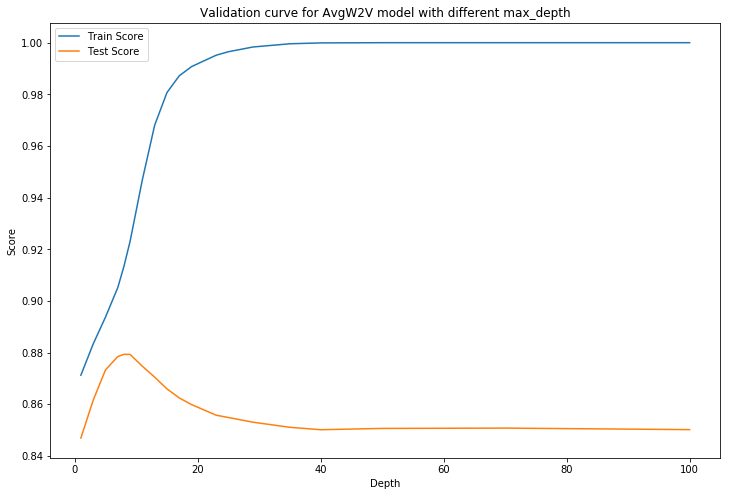

In [17]:
plt.figure(figsize=(12,8))
plt.plot(scores_df.depth,scores_df.Train_score,label='Train Score')
plt.plot(scores_df.depth,scores_df.Test_score,label='Test Score')
plt.title('Validation curve for AvgW2V model with different max_depth')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()

In [18]:
#top scores
scores_df.sort_values('Test_score',ascending=False).head(5)

,depth,Test_score,Test_std,Train_score
4,8,0.879296,0.009600,0.913345
5,9,0.879253,0.008580,0.923057
3,7,0.878424,0.010808,0.905153
6,11,0.874696,0.006940,0.946930
2,5,0.873255,0.013776,0.893709


From cross validation better depth is 8 with Test score of 0.879296.

In [19]:
#testscore
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)


list_of_sent_test=[]
for sent in test_df.final_text.values:
    list_of_sent_test.append(sent.split())
#avg word2vec for 
sent_vector_avgw2v_300_test = avg_w2v(list_of_sent_test,w2v_model_300,300)
#stacking columns
test_avgw2v_300 = np.hstack((sent_vector_avgw2v_300_test,
            test_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
test_df_avgw2v_300 = pd.DataFrame(test_avgw2v_300,columns=column)


model = DT(max_depth=8)
model.fit(train_df_avgw2v_300,train_df.Score)
#Predicting training data
train_list = model.predict(train_df_avgw2v_300)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(test_df_avgw2v_300)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('max_depth',8)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

max_depth 8
Train Score 0.8931115644123646
Test Score 0.8619692268262991
Test Precision 0.8777263581488933
Test Recall 0.9675509027192477
Test ConfusionMatrix [[ 6925 12154]
 [ 2926 87246]]


#### Tf-Idf Weighted Word2Vec

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class TfidfWeightedWord2Vec(BaseEstimator, TransformerMixin):
    '''
    Class for Tfidf Weighted Word2Vec Calculations
    '''
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = word2vec.vector_size
        self.tfidf = None

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer()
        tfidf.fit(X[:,0])
        self.tfidf = tfidf
        #print(self.word2vec.wv.vocab.keys())
        return self
    
    def tf_idf_W2V(self,feature_names,tf_idf_trans_arr,list_of_sent):
        '''
        tfidf weighted word2vec calculation
        '''
        import operator
        dict_tfidf = {k: v for v, k in enumerate(feature_names)}
        sent_vectors = []
        i = 0
        for sent in list_of_sent: # for each review/sentence
            doc = [word for word in sent if word in self.word2vec.wv.vocab.keys()]
            if doc:
                #itemgetter
                f = operator.itemgetter(*doc)
                try:
                    #itemgetter from dict
                    final = f(dict_tfidf)
                    final = tf_idf_trans_arr[i,final]
                    #converting to dense
                    final = final.toarray()
                    #converting to diagnol matrix for multiplication
                    final= np.diag(final[0])
                    sent_vec = np.dot(final,np.array(self.word2vec.wv[doc]))
                    #tfidf weighted word to vec
                    sent_vec = np.sum(sent_vec,axis=0) / np.sum(final)
                except:
                    sent_vec = np.zeros(self.dim)             
            else:
                sent_vec = np.zeros(self.dim)
            sent_vectors.append(sent_vec)
            i = i+1
        return sent_vectors

    def transform(self, X):
        #transform data
        tf_idf_trans_arr = self.tfidf.transform(X[:,0])
        feature_names = self.tfidf.get_feature_names()
        list_of_sent = []
        for sent in X[:,0]:
            list_of_sent.append(sent.split())
        temp_vec = self.tf_idf_W2V(feature_names,tf_idf_trans_arr,list_of_sent)
        temp_vec= np.hstack((temp_vec,X[:,[1,2]]))
        return temp_vec

In [21]:
# For simple cv
#Train data
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(X_train[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(X_train[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(X_test_cv[['final_text',
                 'HelpfulnessNumerator','HelpfulnessDenominator']].values)

In [22]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    model = DT(max_depth=i).fit(X_train_tfw2v,X_train.Score)
    #train score
    train_score = model.score(X_train_tfw2v,X_train.Score)
    #test score
    test_score = model.score(X_cv_tfw2v,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score)

Depth 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Depth 2 Train Score 0.8711360426800565 Test Score 0.8420288718029185
Depth 3 Train Score 0.8711360426800565 Test Score 0.8420288718029185
Depth 4 Train Score 0.8759330658357805 Test Score 0.848174590721272
Depth 5 Train Score 0.8803994530496962 Test Score 0.8514566661436268
Depth 6 Train Score 0.885218892201475 Test Score 0.8531565458444479
Depth 7 Train Score 0.8896068234291991 Test Score 0.8610936764475129
Depth 8 Train Score 0.8948017305148954 Test Score 0.8611590564360061
Depth 9 Train Score 0.9023391091883168 Test Score 0.8621920602541974
Depth 10 Train Score 0.9121461074622851 Test Score 0.8623620482242795
Depth 11 Train Score 0.9238192374078142 Test Score 0.8596945446937602
Depth 12 Train Score 0.9346349555042478 Test Score 0.857850829018254


In [23]:
param_grid = {'decisiontreeclassifier__max_depth':[1,3,5,7,8,9,11,
                          13,15,17,19,23,25,29,35,40,50,70,100]}
model_grid_tfidfw2v = GridSearchCV(make_pipeline(
                    TfidfWeightedWord2Vec(w2v_model_300),DT()),
                    param_grid=param_grid,
                    cv=TimeSeriesSplit(n_splits=10),
                        n_jobs=-1)
model_grid_tfidfw2v.fit(train_df[['final_text','HelpfulnessNumerator',
                     'HelpfulnessDenominator']].values,train_df.Score)

In [26]:
dict_scores = []
idx = 0
for i in model_grid_tfidfw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['decisiontreeclassifier__max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_tfidfw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['depth','Test_score',
                                               'Test_std','Train_score'])

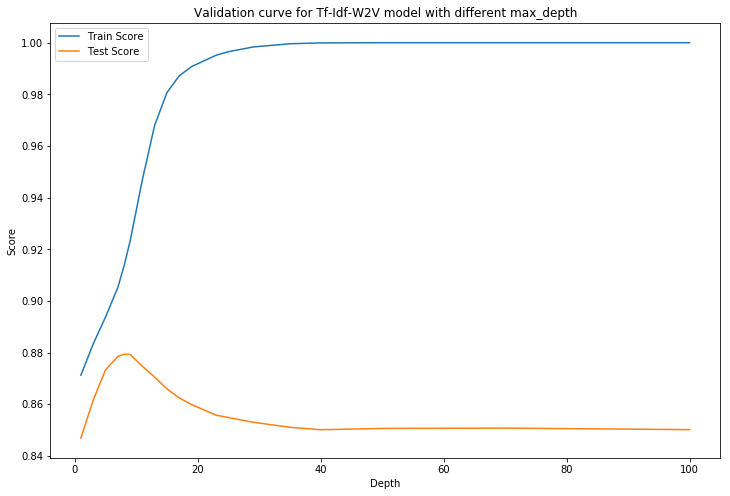

In [27]:
plt.figure(figsize=(12,8))
plt.plot(scores_df1.depth,scores_df.Train_score,label='Train Score')
plt.plot(scores_df1.depth,scores_df.Test_score,label='Test Score')
plt.title('Validation curve for Tf-Idf-W2V model with different max_depth')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()

In [29]:
#top 5 scores
scores_df1.sort_values('Test_score',ascending=False).head(5)

,depth,Test_score,Test_std,Train_score
5,9,0.872741,0.010143,0.916072
4,8,0.872728,0.011507,0.907520
3,7,0.872689,0.013214,0.900727
6,11,0.869556,0.009616,0.936217
2,5,0.866557,0.015469,0.889496


From 10 fold cv we can observe that good depth is 9 with cv score of 0.872741.

In [30]:
#testscore
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(train_df[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(train_df[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(test_df[['final_text',
                 'HelpfulnessNumerator','HelpfulnessDenominator']].values)


model = DT(max_depth=9)
model.fit(X_train_tfw2v,train_df.Score)
#Predicting training data
train_list = model.predict(X_train_tfw2v)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_cv_tfw2v)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('Depth',9)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

Depth 9
Train Score 0.8931586380040797
Test Score 0.8538869209435154
Test Precision 0.8665547048653989
Test Recall 0.9727742536485827
Test ConfusionMatrix [[ 5571 13508]
 [ 2455 87717]]


#### Bag of Words:

In [31]:
#BoW with cleaned data and without stopwords
#simple cv for train data
scores_train = []
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = count_vect.fit_transform(
        X_train['final_text'].values)
#test
X_test = count_vect.transform(X_test_cv['final_text'].values)

In [33]:
for i in [1,3,5,7,9,11,13,15,17,19]:
    model = DT(max_depth=i).fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score)

Depth 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Depth 3 Train Score 0.8621752482571563 Test Score 0.8318034416025942
Depth 5 Train Score 0.8667256954562776 Test Score 0.8381322244887285
Depth 7 Train Score 0.8699760148842214 Test Score 0.8407735760238506
Depth 9 Train Score 0.8807076729954495 Test Score 0.8607275485119514
Depth 11 Train Score 0.8883571316491449 Test Score 0.8659840995867985
Depth 13 Train Score 0.8967070901795521 Test Score 0.8666902034625242
Depth 15 Train Score 0.9028714890946179 Test Score 0.8681154872116742
Depth 17 Train Score 0.9085035081033825 Test Score 0.8693838589884408
Depth 19 Train Score 0.9145838470332429 Test Score 0.8715152466133166


In [34]:
for i in [23,25,27,35,40,45,50,70]:
    model = DT(max_depth=i).fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score)

Depth 23 Train Score 0.9259935890251283 Test Score 0.876549505727287
Depth 25 Train Score 0.9308802761650714 Test Score 0.8764710497410952
Depth 27 Train Score 0.934982403443097 Test Score 0.8760656938124379
Depth 35 Train Score 0.9501524287731725 Test Score 0.8769548616559444
Depth 40 Train Score 0.9572863195176078 Test Score 0.8767456456927664
Depth 45 Train Score 0.9623075026338795 Test Score 0.8764187457503008
Depth 50 Train Score 0.9668187218399049 Test Score 0.8754772739159998
Depth 70 Train Score 0.9780827598574343 Test Score 0.8750980699827396


In [53]:
#grid search
param_grid = {'decisiontreeclassifier__max_depth':[1,3,5,
                      7,8,9,11,13,15,17,19,23,35,50,70]}
model_grid_bow = GridSearchCV(make_pipeline(
            CountVectorizer(stop_words=list(stop),dtype=np.int8),
                                                  DT()),
                                    param_grid=param_grid,
                            cv=TimeSeriesSplit(n_splits=10),
                                                 n_jobs=-1)
model_grid_bow .fit(train_df.final_text.values,train_df.Score)

In [55]:
dict_scores = []
idx = 0
for i in model_grid_bow.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['decisiontreeclassifier__max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_bow.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['depth','Test_score',
                                               'Test_std','Train_score'])

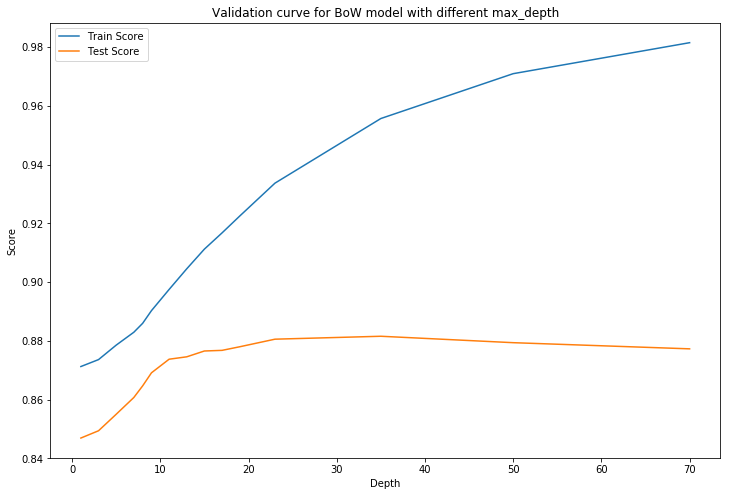

In [56]:
plt.figure(figsize=(12,8))
plt.plot(scores_df.depth,scores_df.Train_score,label='Train Score')
plt.plot(scores_df.depth,scores_df.Test_score,label='Test Score')
plt.title('Validation curve for BoW model with different max_depth')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()

In [57]:
scores_df.sort_values('Test_score',ascending=False)

,depth,Test_score,Test_std,Train_score
12,35,0.881535,0.007312,0.955675
11,23,0.880539,0.007810,0.933671
13,50,0.879348,0.007243,0.970945
10,19,0.877954,0.009595,0.922455
14,70,0.877250,0.007491,0.981497
9,17,0.876733,0.010275,0.916729
8,15,0.876517,0.010974,0.911208
7,13,0.874536,0.011799,0.904508
6,11,0.873721,0.010701,0.897472
5,9,0.869086,0.012684,0.890258


 Depth with 23 to 35 might be better option for bag of words representation of data. for better time complexity and for low variance , maximum depth taken as 23 with mean cv of 0.880539

In [9]:
#Test scores
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
final_counts_train = count_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = count_vect.transform(test_df['final_text'].values)

model = DT(max_depth=23)
model.fit(final_counts_train,train_df.Score)
#Predicting training data
train_list = model.predict(final_counts_train)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('Depth',23)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

Depth 23
Train Score 0.9213243370469166
Test Score 0.8763672643728662
Test Precision 0.9049877972763098
Test Recall 0.9499401144479439
Test ConfusionMatrix [[10086  8993]
 [ 4514 85658]]


In [10]:
import operator
importances = model.feature_importances_
features = count_vect.get_feature_names()
dict_feature = dict(zip(features,importances))
sorted_feature = dict(sorted(dict_feature.items(), key=operator.itemgetter(1),reverse=True))

In [11]:
#To 100 features to seperate the data using Bag of words with RF
list_feature = list(sorted_feature.keys())[0:100]
list_fval = list(sorted_feature.values())[0:100]
print(list_feature)

['not', 'great', 'best', 'disappointed', 'love', 'good', 'worst', 'delicious', 'awful', 'horrible', 'terrible', 'excellent', 'disappointing', 'money', 'favorite', 'bad', 'perfect', 'waste', 'tasty', 'nice', 'yuck', 'wont', 'wa', 'threw', 'disgusting', 'beware', 'find', 'wonderful', 'amazing', 'disappointment', 'thought', 'day', 'rip', 'unfortunately', 'yummy', 'misleading', 'stale', 'poor', 'awesome', 'sweet', 'very', 'product', 'refund', 'year', 'return', 'taste', 'nasty', 'little', 'make', 'store', 'like', 'tasted', 'didnt', 'keep', 'ever', 'bit', 'easy', 'would', 'flavor', 'worse', 'one', 'order', 'get', 'coffee', 'well', 'try', 'found', 'smooth', 'really', 'enjoy', 'even', 'however', 'use', 'time', 'company', 'opened', 'without', 'mediocre', 'never', 'food', 'way', 'review', 'gross', 'longer', 'work', 'cat', 'drink', 'price', 'bland', 'brand', 'changed', 'doe', 'quite', 'nothing', 'ordered', 'customer', 'since', 'buy', 'dog', 'much']


([<matplotlib.axis.XTick at 0x154442851a20>,
 <a list of 50 Text xticklabel objects>)

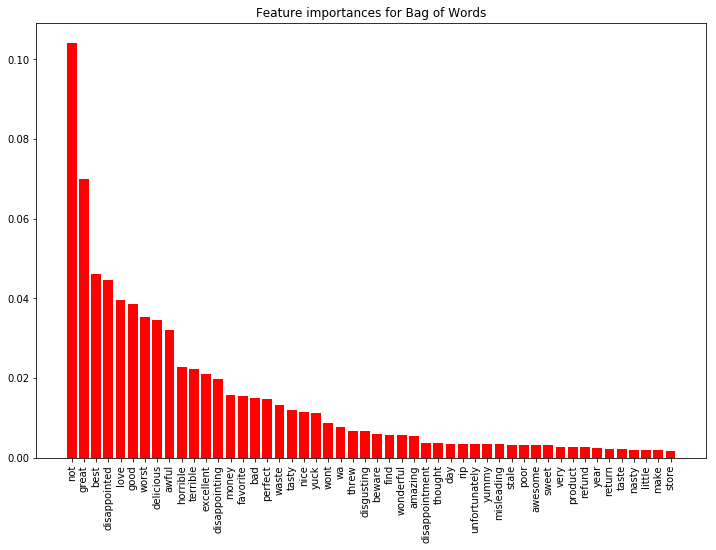

In [12]:
plt.figure(figsize=(12,8))
plt.title("Feature importances for Bag of Words")
plt.bar(range(len(list_feature[0:50])),list_fval[0:50],
       color="r")
plt.xticks(range(len(list_feature[0:50])), 
           list_feature[0:50],rotation = 90)

#### Tf-Idf

In [60]:
#TFIDF with (1,2) gram with cleaned data 
#simple cv for train data
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = tf_idf_vect.fit_transform(
        X_train['final_text'].values)
#test
X_test = tf_idf_vect.transform(X_test_cv['final_text'].values)

In [61]:
for i in [1,3,5,7,9,11,13,15,17,19]:
    model = DT(max_depth=i).fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score)

Depth 1 Train Score 0.8600121046378696 Test Score 0.8293451540352529
Depth 3 Train Score 0.8622481002443344 Test Score 0.8319342015795805
Depth 5 Train Score 0.868266795185044 Test Score 0.8390998483184267
Depth 7 Train Score 0.8752717939521643 Test Score 0.8560201893404467
Depth 9 Train Score 0.8867431799332003 Test Score 0.8646241958261416
Depth 11 Train Score 0.8949250184931967 Test Score 0.8700245828756734
Depth 13 Train Score 0.9030508170630562 Test Score 0.8715283226110152
Depth 15 Train Score 0.9088677680392728 Test Score 0.8721036665097547
Depth 17 Train Score 0.9153459908991056 Test Score 0.8743658141116167
Depth 19 Train Score 0.9211965658694045 Test Score 0.8762487577802186


In [12]:
for i in [23,25,27,35,40,45]:
    model = DT(max_depth=i).fit(final_counts_train,X_train.Score)
    #train score
    train_score = model.score(final_counts_train,X_train.Score)
    #test score
    test_score = model.score(X_test,X_test_cv.Score)
    print('Depth',i,'Train Score',train_score,'Test Score',test_score)

Depth 23 Train Score 0.9326735558494542 Test Score 0.8789816412992312
Depth 25 Train Score 0.9371511510613975 Test Score 0.8800538731105183
Depth 27 Train Score 0.9402669745130124 Test Score 0.8804069250483811
Depth 35 Train Score 0.9523716123825963 Test Score 0.8829175166065171
Depth 40 Train Score 0.959421443141826 Test Score 0.8833228725351744
Depth 45 Train Score 0.9646275582255498 Test Score 0.8819368167791203


In [42]:
param_grid = {'decisiontreeclassifier__max_depth':
                 [1,3,5,7,9,11,13,15,17,19,23,35,40,60,90]}
model_grid_tfidf = GridSearchCV(make_pipeline(
                    TfidfVectorizer(ngram_range=(1,2)),DT()),
                                    param_grid=param_grid,
                                cv=TimeSeriesSplit(n_splits=10),
                                                     n_jobs=-1)
model_grid_tfidf.fit(train_df.final_text.values,train_df.Score)

In [43]:
dict_scores = []
idx = 0
for i in model_grid_tfidf.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['decisiontreeclassifier__max_depth'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_tfidf.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['depth','Test_score',
                                               'Test_std','Train_score'])

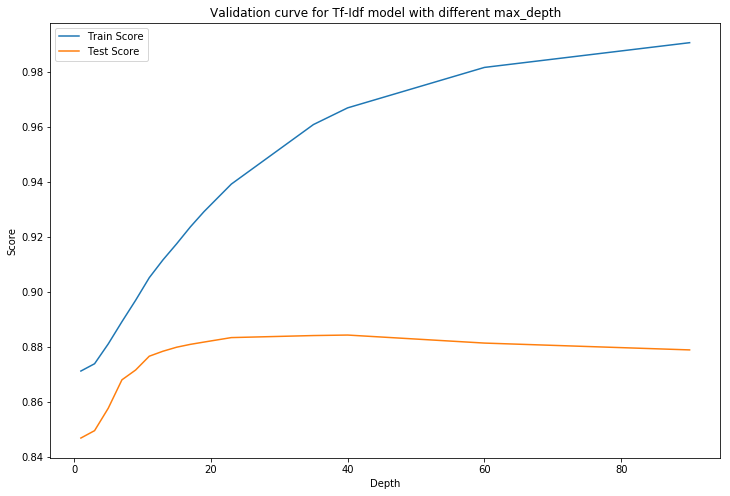

In [44]:
plt.figure(figsize=(12,8))
plt.plot(scores_df.depth,scores_df.Train_score,label='Train Score')
plt.plot(scores_df.depth,scores_df.Test_score,label='Test Score')
plt.title('Validation curve for Tf-Idf model with different max_depth')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend()

In [46]:
scores_df.sort_values('Test_score',ascending=False).head(10)

,depth,Test_score,Test_std,Train_score
12,40,0.884301,0.005215,0.966856
11,35,0.884120,0.005923,0.960791
10,23,0.883378,0.008458,0.939165
9,19,0.881751,0.009670,0.929148
13,60,0.881384,0.005097,0.981552
8,17,0.880918,0.010221,0.923587
7,15,0.879883,0.010582,0.917458
14,90,0.878903,0.005205,0.990540
6,13,0.878424,0.011582,0.911619
5,11,0.876616,0.012583,0.905149


Better scores is greater than 23 and 23 is good to choose with mean cv of 0.883378

In [13]:
#test scores
#TFIDF with (1,2) gram with cleaned data 
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_counts_train = tf_idf_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = tf_idf_vect.transform(test_df['final_text'].values)

model = DT(max_depth=23,random_state=25)
model.fit(final_counts_train,train_df.Score)
#Predicting training data
train_list = model.predict(final_counts_train)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('depth',23)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

depth 23
Train Score 0.926549505727287
Test Score 0.8802482357140896
Test Precision 0.9094772179197076
Test Recall 0.9494077984296677
Test ConfusionMatrix [[10558  8521]
 [ 4562 85610]]


In [14]:
import operator
importances = model.feature_importances_
features = count_vect.get_feature_names()
dict_feature = dict(zip(features,importances))
sorted_feature = dict(sorted(dict_feature.items(), key=operator.itemgetter(1),reverse=True))

In [15]:
#To 100 features to seperate the data using Bag of words with RF
list_feature = list(sorted_feature.keys())[0:100]
list_fval = list(sorted_feature.values())[0:100]
print(list_feature)

['ovaltine', 'smartdogs', 'minuscule', 'ambivalence', 'everwhere', 'ob', 'wildeberryaki', 'untraceable', 'wrangling', 'benzyl', 'prima', 'domesticate', 'stroke', 'greediest', 'nawob', 'duetto', 'cloveaload', 'jaudie', 'withing', 'goldenflax', 'hagaman', 'williamsburg', 'ladygrey', 'undisturbed', 'craze', 'bilbo', 'disapproving', 'undercut', 'aa', 'aachen', 'aachener', 'aaf', 'aagghh', 'aah', 'aahhyaa', 'aahing', 'aahs', 'aammaazziinngg', 'aap', 'aardvark', 'aargh', 'aaron', 'aarp', 'aarrgh', 'aarrghh', 'aauw', 'ab', 'aback', 'abacus', 'abada', 'abalone', 'abamectin', 'abandon', 'abandoned', 'abandoning', 'abash', 'abated', 'abates', 'abattoir', 'abb', 'abba', 'abbas', 'abbazabba', 'abbey', 'abbie', 'abbondanza', 'abbot', 'abbott', 'abbreviated', 'abbreviating', 'abbreviation', 'abby', 'abc', 'abcstores', 'abd', 'abdomen', 'abdominal', 'abduct', 'abe', 'abel', 'aberdeen', 'aberfoyle', 'abernook', 'aberrant', 'aberration', 'abetter', 'abhor', 'abhorrent', 'abhors', 'abi', 'abid', 'abide'

([<matplotlib.axis.XTick at 0x1543f38bef98>,
 <a list of 50 Text xticklabel objects>)

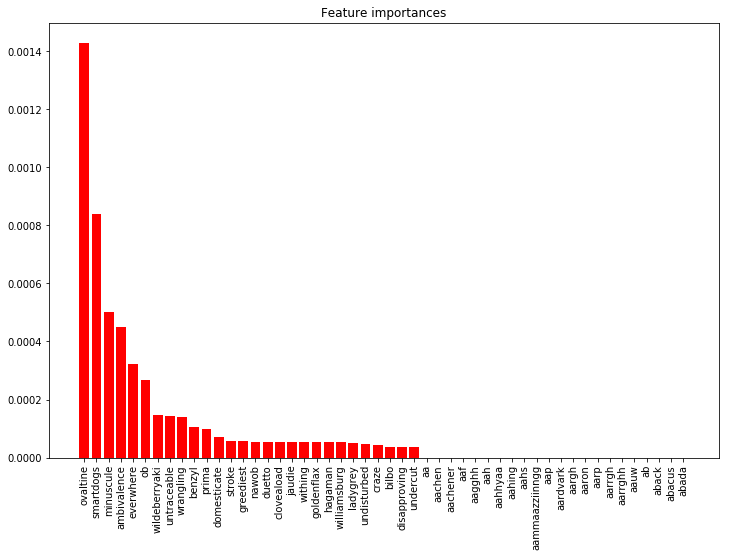

In [16]:
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(len(list_feature[0:50])),list_fval[0:50],
       color="r")
plt.xticks(range(len(list_feature[0:50])), 
           list_feature[0:50],rotation = 90)

#### Observations:<br>
1. For Avg Word2Vec representation of data got best cv at depth = 8 and mean cv score is 0.879296.
    *  Train Score 0.8931115644123646
    *  Test Score 0.8619692268262991
    *  Test Precision 0.8777263581488933
    *  Test Recall 0.9675509027192477
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 6925 & 12154 &  \\
    & 2926 & 87246 & 
    \end{bmatrix}
    \end{equation}
<br>
2. For Tf-Idf Word2Vec representation got best cv at depth = 9 with cv score of 0.872741.
    *  Train Score 0.8931586380040797
    *  Test Score 0.8538869209435154
    *  Test Precision 0.8665547048653989
    *  Test Recall 0.9727742536485827
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 5571 & 13508 &  \\
    & 2455 & 87717 & 
    \end{bmatrix}
    \end{equation}
<br>
3. For Bag of Words representation , got best cv at depth = 23 with mean cv score of 0.880539.
    *  Train Score 0.9211909618703907
    *  Test Score 0.8762848852642081
    *  Test Precision 0.9049873203719357
    *  Test Recall 0.9498292152774698
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 10087 & 8992 &  \\
    & 4524 & 85648 & 
    \end{bmatrix}
    \end{equation}
<br>
4. For Tf-Idf with bi-gram representation, got best cv at depth = 23 is  with mean cv score of 0.883378.
    *  Train Score 0.926549505727287
    *  Test Score 0.8802482357140896
    *  Test Precision 0.9094772179197076
    *  Test Recall 0.9494077984296677
    *  Test ConfusionMatrix 
    \begin{equation}
    \begin{bmatrix}
    & 10558 & 8521 &  \\
    & 4562 & 85610 & 
    \end{bmatrix}
    \end{equation}
<br>